In [22]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from mlresearch.utils import check_pipelines, set_matplotlib_style
from mlresearch.model_selection import ModelSearchCV

from sharp import ShaRP
from sharp.utils import scores_to_ordering

import matplotlib.pyplot as plt

In [12]:
# Download German Credit
URL = "https://zenodo.org/records/14052137/files/german_credit.csv"
df = pd.read_csv(URL)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.rename(columns={"Label": "target"}, inplace=True)
df.index.name = "ID"
df.target = df.target - 1

X = df.drop(columns=["target"])
y = df["target"]

df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,target
ID,,,,,,,,,,,,,,,,,,,,,
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [13]:
# Get metadata
META_URL = "https://zenodo.org/records/14052137/files/german_credit_attribute_info.csv"
df_meta = pd.read_csv(META_URL)
df_meta = df_meta[df_meta["name"] != "class"]

categorical_features = df_meta[df_meta["type"].isin(["Categorical", "Binary"])]["name"].tolist()
categorical_features

['Attribute1',
 'Attribute3',
 'Attribute4',
 'Attribute6',
 'Attribute7',
 'Attribute9',
 'Attribute10',
 'Attribute12',
 'Attribute14',
 'Attribute15',
 'Attribute17',
 'Attribute19',
 'Attribute20']

In [14]:
CONFIG = {
    "ENCODER": [
        (
            "PREP",
            ColumnTransformer(
                transformers=[
                    ("OHE", OneHotEncoder(sparse_output=False), categorical_features)
                ],
                remainder=StandardScaler(),
                force_int_remainder_cols=False
            ),
            {},
        )
    ],
    "CLASSIFIERS": [
        (
            "RF",
            RandomForestClassifier(),
            {
                "criterion": ["gini", "entropy"],
                "n_estimators": [10, 100, 1000],
                "max_depth": [5, 10],
            },
        ),
    ],
    "N_SPLITS": 5,
    "N_RUNS": 1,
    "RANDOM_STATE": 42,
    "N_JOBS": -1,
}

pipelines, params = check_pipelines(
    CONFIG["ENCODER"],
    CONFIG["CLASSIFIERS"],
    random_state=CONFIG["RANDOM_STATE"],
    n_runs=CONFIG["N_RUNS"],
)

# Run parameter tuning
clf = ModelSearchCV(
    estimators=pipelines,
    param_grids=params,
    scoring="f1",
    n_jobs=CONFIG["N_JOBS"],
    cv=CONFIG["N_SPLITS"],
    verbose=1,
    refit=True,
).fit(X, y).best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [17]:
columns = X.columns.tolist()
scores = clf.predict_proba(X)[:, 1]
ranks = scores_to_ordering(scores, -1)

def target_function(X: np.ndarray) -> np.ndarray:
    return clf.predict_proba(pd.DataFrame(X, columns=columns))[:, 1]

xai = ShaRP(
    qoi="rank", 
    target_function=target_function, 
    measure="unary", 
    sample_size=100, 
    random_state=CONFIG["RANDOM_STATE"],
    n_jobs=CONFIG["N_JOBS"],
    verbose=1,
)
xai.fit(X)

In [18]:
# Get a sample of points, 10 from each rank stratum
# X_test, ranks, scores
rng = np.random.default_rng(CONFIG["RANDOM_STATE"])
n_samples_total = 100
n_bins = 10
bins = np.linspace(0, ranks.max()+1, n_bins+1)
strata = np.digitize(ranks, bins)

n_samples_bin = int(np.round((n_samples_total / n_bins)))
indices = []
for i in np.unique(strata):
    ids_ = np.where(strata==i)[0].tolist()
    ids_ = rng.choice(ids_, n_samples_bin)
    indices += ids_.tolist()

indices = np.array(indices)

contributions = pd.DataFrame(xai.all(X.iloc[indices]), columns=X.columns, index=X.iloc[indices].index)

  0%|          | 0/100 [00:00<?, ?it/s]

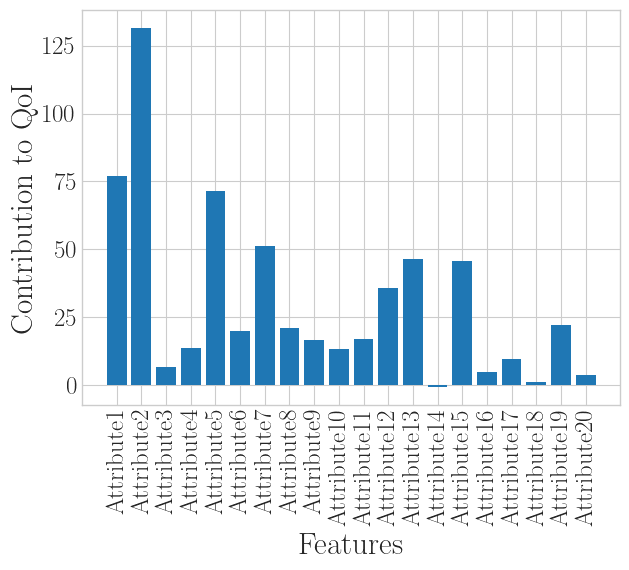

In [29]:
set_matplotlib_style(18)
# xai.plot.box(X.iloc[indices], ranks[indices], contributions, feature_names=X.columns, group=10)
xai.plot.bar(contributions.iloc[0])
plt.xticks(rotation=90)
plt.show()